In [1]:
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import cartopy.crs as ccrs
import glob
import numpy as np

In [2]:
# Creates sorted list of cities in the dataset
cities = [
    'Jacksonville', 'DMV', 'NYC', 'Phoenix', 'Miami', 'Chicago', 'Denver', 'Seattle', 'San_Francisco', 'Los_Angeles', 'Atlanta', 'Toronto',
    'Mexico_City', 'Las_Vegas', 'Salt_Lake_City', 'Dallas', 'Houston', 'New_Orleans', 'St_Louis', 'Minneapolis',
    'Charlotte', 'Philadelphia', 'San_Diego', 'San_Juan', 'Montreal', 'Guadalajara', 'Monterrey', 'Cancun', 'Billings', 'Guatemala_City',
    'San_Jose', 'Havana', 'Santo_Domingo', 'Tegucigalpa', 'Managua', 'Panama_City', 'Bogota', 'Lima', 'Quito', 'Santiago', 'Buenos_Aires',
    'Sao_Paulo', 'Manaus', 'Punta_Arenas', 'La_Paz', 'Montevideo', 'Brasilia', 'Caracas'
]
cities = sorted(cities)

In [3]:
# Gets a list of a single GOES data file for each city in the dataset
geo_tiff_files = [sorted(glob.glob(f'/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/{city}/GOES_2022_2/*'))[0] for city in cities]

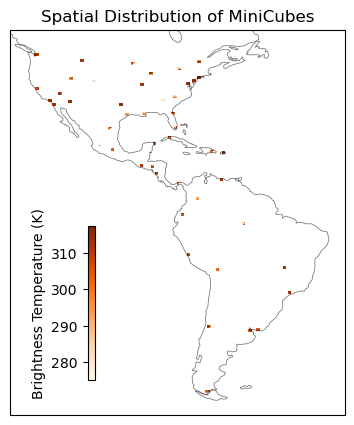

In [14]:
# Create a figure with a Cartopy projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
max = 0

# Open the input GeoTIFF
for file in geo_tiff_files:
    with rasterio.open(file) as src:
        # Define the target CRS (e.g., WGS84 geographic coordinates)
        dst_crs = 'EPSG:4326'

        # Calculate the transform and dimensions for the reprojected image
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        # Define the output profile
        kwargs = src.profile.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create the output GeoTIFF and reproject the data
        with rasterio.open('output.tif', 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),  # Reproject the first band
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest  # Choose a resampling method
            )

        # Plot the output file
        file = 'output.tif'
        src = rasterio.open(file)
        # Read the first band
        band1 = src.read(1)
        local_max = np.nanmax(band1)
        if local_max > max:
            max = local_max

        # Plot the data
        show((src, 1), transform=src.transform, ax=ax, cmap='Oranges', vmin=275)

# Set a custom colorbar
scalar_mappable = cm.ScalarMappable(
        norm=colors.Normalize(vmin=275, vmax=max),
        cmap='Oranges')
fig.colorbar(scalar_mappable, location='left', ax=ax, anchor=(2.5, 0.15), shrink=0.4, label='Brightness Temperature (K)')

# Set global extent
ax.set_global()

# Add coastlines for reference
ax.coastlines(alpha=0.6, lw=0.5)

# Limit coverage area
ax.set_xlim(left=-130, right=-30)
ax.set_ylim(bottom=-60, top=55)

# Add a title
plt.title('Spatial Distribution of MiniCubes')

# Show the plot and save it as an SVG
plt.savefig('/glade/derecho/scratch/jstarfeldt/data_analysis/spatial_cubes.svg', bbox_inches='tight', transparent=True)